In [1]:
# %%
# Import necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from shapely.geometry import Polygon, Point
import pyproj
import os
import ee
import geemap
import sys
import logging
import matplotlib.pyplot as plt
from io import BytesIO


# Add the src directory to the sys.path
sys.path.append(os.path.abspath('..'))

# Import functions from your secret_runway_detection package
from secret_runway_detection import train_utils, dataset

# Initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# Set random seed for reproducibility
import random
random.seed(train_utils.RANDOM_SEED)

logging.basicConfig(level=logging.INFO)
# logging.getLogger('secret_runway_detection.train_utils').setLevel(logging.DEBUG)
logging.getLogger('secret_runway_detection.train_utils').setLevel(logging.INFO)


In [2]:
# %%
# Define the path to the landing strips shapefile
landing_strips_shapefile = '../pac_2024_training/pac_2024_training.shp'

# Check if the shapefile exists
if not os.path.exists(landing_strips_shapefile):
    raise FileNotFoundError(f"Shapefile not found at {landing_strips_shapefile}")

# Read the landing strips shapefile
landing_strips = gpd.read_file(landing_strips_shapefile)

# Print the number of landing strips loaded
print(f"Number of landing strips loaded: {len(landing_strips)}")

# Display the first few rows
landing_strips.head()


Number of landing strips loaded: 154


,id,yr,largo,Activo,geometry
0,1,2023,968.918,0,"LINESTRING (-70.08929 -13.12984, -70.08053 -13..."
1,2,2022,1105.491,0,"LINESTRING (-69.16744 -13.62068, -69.17286 -13..."
2,3,2015,985.018,0,"LINESTRING (-69.14225 -13.69451, -69.14190 -13..."
3,4,2020,681.914,0,"LINESTRING (-69.07844 -13.78790, -69.08404 -13..."
4,5,2020,699.552,0,"LINESTRING (-69.07838 -13.78788, -69.08279 -13..."


In [3]:
print(type(landing_strips.iloc[0].geometry))

<class 'shapely.geometry.linestring.LineString'>


In [4]:
# %%
# Define the number of tiles per side length for input areas
num_tiles_per_area_side_len = train_utils.TILES_PER_AREA_LEN  # Assuming this is defined in train_utils

# Generate input areas using the provided function
input_areas = train_utils.landing_strips_to_enclosing_input_areas(
    landing_strips=landing_strips,
    num_tiles_per_area_side_len=num_tiles_per_area_side_len
)

# Print the number of input areas generated
print(f"Number of input areas generated: {len(input_areas)}")

# Display the first few input areas
input_areas.head()

INFO:secret_runway_detection.train_utils:Total overlapping areas: 20


Number of input areas generated: 154


,geometry
0,"POLYGON ((-70.10135 -13.14223, -70.08297 -13.1..."
1,"POLYGON ((-69.17336 -13.62473, -69.15496 -13.6..."
2,"POLYGON ((-69.15848 -13.69741, -69.14008 -13.6..."
3,"POLYGON ((-69.09276 -13.79723, -69.07435 -13.7..."
4,"POLYGON ((-69.09308 -13.79442, -69.07468 -13.7..."


In [5]:
# %%
# Select one input area to work with (e.g., the first one)
selected_input_area = input_areas.iloc[0]['geometry']

# Get the CRS of the input area
input_area_crs = input_areas.crs

# Generate the has_strip tensor for the selected input area
has_strip_tensor = train_utils.input_area_to_has_strip_tensor(
    landing_strips=landing_strips,
    input_area=selected_input_area,
    input_area_crs=input_area_crs,
    tiles_per_area_len=num_tiles_per_area_side_len,
    
)

print(f"has_strip_tensor shape: {has_strip_tensor.shape}")
print(f"Number of runway tiles: {has_strip_tensor.sum()}")

has_strip_tensor shape: torch.Size([200, 200])
Number of runway tiles: 4060.0


In [6]:

# get time period for images
start_date, end_date = train_utils.get_time_period_of_strips_on_area(landing_strips, selected_input_area, input_area_crs)
print(f"Got times: {start_date} and {end_date}")

end_date = start_date + pd.DateOffset(years=1)

# Generate the satellite image for the selected input area
satellite_image = train_utils.input_area_to_input_image(
    input_area=selected_input_area,
    image_data_start_date=start_date,
    image_data_end_date=end_date,
    input_area_crs=input_area_crs,
)

print(f"Satellite image shape: {satellite_image.shape}")
# print(f"Satellite image: {satellite_image}")

# # Display the satellite image
# plt.imshow(np.transpose(satellite_image, (1, 2, 0)))
# plt.title("Satellite Image")
# plt.axis('on')
# plt.show()


Got times: 2023-01-01 00:00:00 and 2023-12-31 00:00:00
Satellite image shape: (3, 224, 224)
Satellite image: [[[0.14509805 0.14509805 0.14509805 ... 0.8980392  0.91764706 0.91764706]
  [0.14901961 0.15294118 0.13333334 ... 0.9019608  0.9098039  0.9098039 ]
  [0.13725491 0.15294118 0.14509805 ... 0.84313726 0.827451   0.827451  ]
  ...
  [0.14117648 0.14117648 0.16078432 ... 0.14901961 0.14117648 0.14509805]
  [0.14509805 0.13725491 0.14901961 ... 0.14509805 0.14901961 0.14509805]
  [0.14901961 0.1254902  0.13333334 ... 0.15294118 0.15686275 0.15686275]]

 [[0.20392157 0.20784314 0.2        ... 0.72156864 0.74509805 0.74509805]
  [0.19607843 0.20784314 0.19215687 ... 0.7294118  0.74509805 0.74509805]
  [0.19215687 0.21568628 0.22352941 ... 0.6901961  0.6862745  0.6862745 ]
  ...
  [0.21176471 0.2        0.23921569 ... 0.21568628 0.20784314 0.20392157]
  [0.21960784 0.19607843 0.21960784 ... 0.21960784 0.23137255 0.21960784]
  [0.21960784 0.1882353  0.20784314 ... 0.22745098 0.23921569 0

In [7]:
# inspect crs of landing strips and input area
print(landing_strips.crs)
print(input_areas.crs)
print(input_area_crs)

# Update the input_area_crs variable to the new CRS
# input_area_crs = pyproj.CRS('EPSG:3857')

# Confirm the reprojection
print("Reprojected CRS:")
print(f"Landing Strips CRS: {landing_strips.crs}")
print(f"Input Areas CRS: {input_areas.crs}")
print(f"Input Area CRS Variable: {input_area_crs}")

# Display a sample of the reprojected data
print("\nSample Landing Strips:")
print(landing_strips.head())

print("\nSample Input Areas:")
print(input_areas.head())


EPSG:4326
EPSG:4326
EPSG:4326
Reprojected CRS:
Landing Strips CRS: EPSG:4326
Input Areas CRS: EPSG:4326
Input Area CRS Variable: EPSG:4326

Sample Landing Strips:
   id    yr     largo  Activo  \
0   1  2023   968.918       0   
1   2  2022  1105.491       0   
2   3  2015   985.018       0   
3   4  2020   681.914       0   
4   5  2020   699.552       0   

                                            geometry  
0  LINESTRING (-70.08929 -13.12984, -70.08053 -13...  
1  LINESTRING (-69.16744 -13.62068, -69.17286 -13...  
2  LINESTRING (-69.14225 -13.69451, -69.14190 -13...  
3  LINESTRING (-69.07844 -13.78790, -69.08404 -13...  
4  LINESTRING (-69.07838 -13.78788, -69.08279 -13...  

Sample Input Areas:
                                            geometry
0  POLYGON ((-70.10135 -13.14223, -70.08297 -13.1...
1  POLYGON ((-69.17336 -13.62473, -69.15496 -13.6...
2  POLYGON ((-69.15848 -13.69741, -69.14008 -13.6...
3  POLYGON ((-69.09276 -13.79723, -69.07435 -13.7...
4  POLYGON ((-69.09308

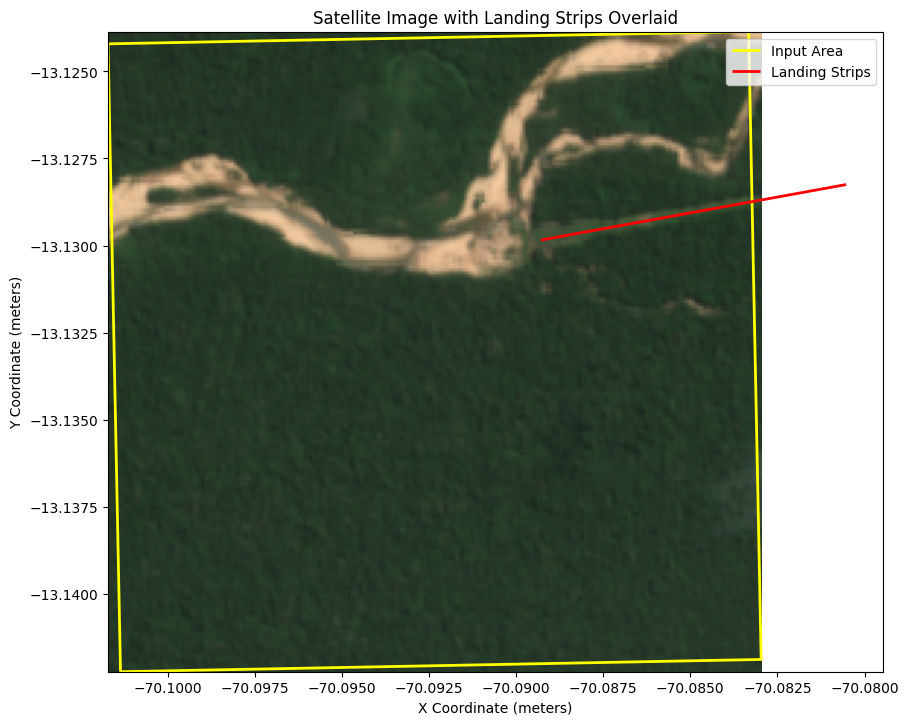

In [8]:
def plot_satellite_with_strips(
    satellite_image: np.ndarray, 
    input_area: Polygon, 
    landing_strips: gpd.GeoDataFrame, 
    crs: pyproj.CRS
):
    """
    Plots the satellite image with landing strips overlaid and displays coordinate axes.
    
    Parameters:
    - satellite_image (np.ndarray): Satellite image array with shape (C, H, W).
    - input_area (Polygon): The input area polygon.
    - landing_strips (gpd.GeoDataFrame): GeoDataFrame containing landing strip polygons.
    - crs (pyproj.CRS): Coordinate Reference System of the data.
    """
    # Convert satellite_image from (C, H, W) to (H, W, C) for plotting
    satellite_image_rgb = np.transpose(satellite_image, (1, 2, 0))
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Define the extent based on the input area bounds
    minx, miny, maxx, maxy = input_area.bounds
    extent = [minx, maxx, miny, maxy]
    
    # Display the satellite image
    ax.imshow(satellite_image_rgb, extent=extent)
    
    # Create a GeoSeries for the input area
    input_area_gs = gpd.GeoSeries([input_area], crs=crs)
    
    # Plot the input area boundary
    input_area_gs.boundary.plot(edgecolor='yellow', linewidth=2, ax=ax, label='Input Area')
    
   # Filter landing strips to include only those that intersect with the input area
    overlapping_strips = landing_strips[landing_strips.intersects(input_area)]
    
    # Plot the overlapping landing strips
    overlapping_strips.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Landing Strips')
    
    # Add legend
    ax.legend(loc='upper right')
    
    # Add coordinate axes labels
    ax.set_xlabel('X Coordinate (meters)')
    ax.set_ylabel('Y Coordinate (meters)')
    
    # Set aspect ratio to 'equal' to maintain scale
    ax.set_aspect('equal', adjustable='box')
    
    # Show the plot
    plt.title('Satellite Image with Landing Strips Overlaid')
    plt.show()


# Plot the satellite image with landing strips overlaid
plot_satellite_with_strips(
    satellite_image=satellite_image,
    input_area=selected_input_area,
    landing_strips=landing_strips,
    crs=input_area_crs
)


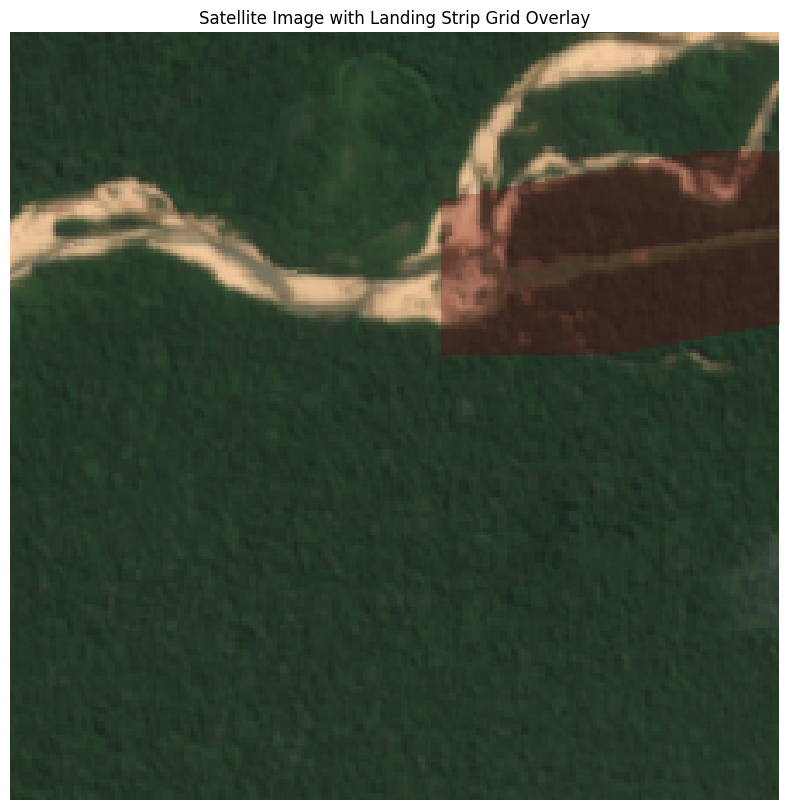

In [9]:
# %%
def plot_satellite_with_tensor_grid(satellite_image: np.ndarray, has_strip_tensor: torch.Tensor, tiles_per_area_len: int):
    """
    Plots the satellite image with a grid overlay indicating landing strip presence.

    Parameters:
    - satellite_image (np.ndarray): Satellite image array with shape (C, H, W).
    - has_strip_tensor (torch.Tensor): Tensor indicating landing strip presence in each tile.
    - tiles_per_area_len (int): Number of tiles per side.
    """
    # Convert satellite_image from (C, H, W) to (H, W, C) for plotting
    satellite_image_rgb = np.transpose(satellite_image, (1, 2, 0))
    
    # Normalize the image for display (assuming values are between 0 and 1)
    satellite_image_rgb = np.clip(satellite_image_rgb, 0, 1)
    
    # Create a figure
    plt.figure(figsize=(10, 10))
    
    # Display the satellite image
    plt.imshow(satellite_image_rgb)
    
    # Overlay the has_strip tensor
    has_strip_np = has_strip_tensor.numpy()
    
    # Create a color map where 0 is transparent and 1 is red with some transparency
    cmap = plt.cm.Reds
    cmap.set_under(color='none')  # Set color for values below the threshold (0)
    
    # Plot the tensor as a semi-transparent overlay
    plt.imshow(
        has_strip_np, 
        cmap=cmap, 
        alpha=0.3, 
        interpolation='nearest',
        extent=[0, satellite_image_rgb.shape[1], satellite_image_rgb.shape[0], 0],
        vmin=0.1  # Ensures that 0 values are transparent
    )
    
    # Remove axes
    plt.axis('off')
    
    # Add title
    plt.title('Satellite Image with Landing Strip Grid Overlay')
    
    # Show the plot
    plt.show()

# Plot the satellite image with has_strip tensor grid overlay
plot_satellite_with_tensor_grid(
    satellite_image=satellite_image,
    # satellite_image=np.ones(satellite_image.shape),
    has_strip_tensor=has_strip_tensor,
    tiles_per_area_len=num_tiles_per_area_side_len,
)
